## Соревнование по классификации

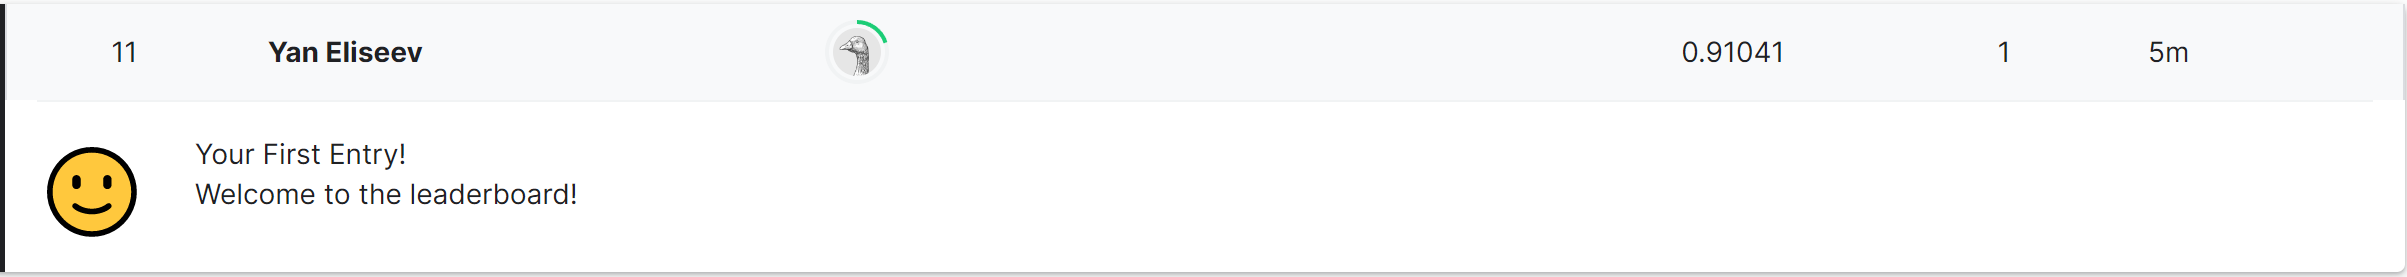

### Результат: Метрика F1 > 0.9

# Import

In [1]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

In [2]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, cv, Pool
from sklearn.ensemble import RandomForestClassifier
# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

### Скачиваем данные

In [3]:
# данные которые "все"
ass = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
# results = pd.read_csv('studentAssessment.csv')
info = pd.read_csv('studentInfo.csv')
reg = pd.read_csv('studentRegistration.csv')
studentVle = pd.read_csv('studentVle.csv')
vle = pd.read_csv('vle.csv')

In [4]:
Train_Who = pd.read_csv('Train_Who.csv')
Test_Who = pd.read_csv('Test_Who.csv')

In [55]:
ass = ass.fillna(0)
ass.head()

code_module code_presentation  id_assessment assessment_type   date  weight
0         AAA             2013J           1752             TMA   19.0    10.0
1         AAA             2013J           1753             TMA   54.0    20.0
2         AAA             2013J           1754             TMA  117.0    20.0
3         AAA             2013J           1755             TMA  166.0    20.0
4         AAA             2013J           1756             TMA  215.0    30.0

In [56]:
reg = reg.fillna(0)
reg.head()

code_module code_presentation  id_student  date_registration
0         AAA             2013J       11391             -159.0
1         AAA             2013J       28400              -53.0
2         AAA             2013J       30268              -92.0
3         AAA             2013J       31604              -52.0
4         AAA             2013J       32885             -176.0

In [57]:
vle = vle.fillna(0)
vle.head()

id_site code_module code_presentation activity_type  week_from  week_to
0   546943         AAA             2013J      resource        0.0      0.0
1   546712         AAA             2013J     oucontent        0.0      0.0
2   546998         AAA             2013J      resource        0.0      0.0
3   546888         AAA             2013J           url        0.0      0.0
4   547035         AAA             2013J      resource        0.0      0.0

In [58]:
info = info.fillna(0)
info.head()

code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability  
0              240          N  
1               60          N  
2               60          Y  
3               60          N  
4               60          N

## Cливаем всё в одну таблицу

#### Объединим info и courses ( информация о студенте и о курсах)

In [31]:
df1 = pd.merge(info, courses, on=['code_module', 'code_presentation'], how='inner')
df1

code_module code_presentation  id_student gender                region  \
0             AAA             2013J       11391      M   East Anglian Region   
1             AAA             2013J       28400      F              Scotland   
2             AAA             2013J       30268      F  North Western Region   
3             AAA             2013J       31604      F     South East Region   
4             AAA             2013J       32885      F  West Midlands Region   
...           ...               ...         ...    ...                   ...   
32588         GGG             2014J     2640965      F                 Wales   
32589         GGG             2014J     2645731      F   East Anglian Region   
32590         GGG             2014J     2648187      F          South Region   
32591         GGG             2014J     2679821      F     South East Region   
32592         GGG             2014J     2684003      F      Yorkshire Region   

           highest_education imd_band age_band  num_of_prev_attempts  \
0           HE Qualification  90-100%     55<=                     0   
1           HE Qualification   20-30%    35-55                     0   
2      A Level or Equivalent   30-40%    35-55                     0   
3      A Level or Equivalent   50-60%    35-55                     0   
4         Lower Than A Level   50-60%     0-35                     0   
...                      ...      ...      ...                   ...   
32588     Lower Than A Level    10-20     0-35                     0   
32589     Lower Than A Level   40-50%    35-55                     0   
32590  A Level or Equivalent   20-30%     0-35                     0   
32591     Lower Than A Level  90-100%    35-55                     0   
32592       HE Qualification   50-60%    35-55                     0   

       studied_credits disability  module_presentation_length  
0                  240          N                         268  
1                   60          N                         268  
2                   60          Y                         268  
3                   60          N                         268  
4                   60          N                         268  
...                ...        ...                         ...  
32588               30          N                         269  
32589               30          N                         269  
32590               30          Y                         269  
32591               30          N                         269  
32592               30          N                         269  

[32593 rows x 12 columns]

#### Добавим информацию о дате регистрации студента на курс

In [32]:
df2 = pd.merge(reg, df1, on=['code_module', 'code_presentation', 'id_student'], how='inner')
df2

code_module code_presentation  id_student  date_registration gender  \
0             AAA             2013J       11391             -159.0      M   
1             AAA             2013J       28400              -53.0      F   
2             AAA             2013J       30268              -92.0      F   
3             AAA             2013J       31604              -52.0      F   
4             AAA             2013J       32885             -176.0      F   
...           ...               ...         ...                ...    ...   
32588         GGG             2014J     2640965               -4.0      F   
32589         GGG             2014J     2645731              -23.0      F   
32590         GGG             2014J     2648187             -129.0      F   
32591         GGG             2014J     2679821              -49.0      F   
32592         GGG             2014J     2684003              -28.0      F   

                     region      highest_education imd_band age_band  \
0       East Anglian Region       HE Qualification  90-100%     55<=   
1                  Scotland       HE Qualification   20-30%    35-55   
2      North Western Region  A Level or Equivalent   30-40%    35-55   
3         South East Region  A Level or Equivalent   50-60%    35-55   
4      West Midlands Region     Lower Than A Level   50-60%     0-35   
...                     ...                    ...      ...      ...   
32588                 Wales     Lower Than A Level    10-20     0-35   
32589   East Anglian Region     Lower Than A Level   40-50%    35-55   
32590          South Region  A Level or Equivalent   20-30%     0-35   
32591     South East Region     Lower Than A Level  90-100%    35-55   
32592      Yorkshire Region       HE Qualification   50-60%    35-55   

       num_of_prev_attempts  studied_credits disability  \
0                         0              240          N   
1                         0               60          N   
2                         0               60          Y   
3                         0               60          N   
4                         0               60          N   
...                     ...              ...        ...   
32588                     0               30          N   
32589                     0               30          N   
32590                     0               30          Y   
32591                     0               30          N   
32592                     0               30          N   

       module_presentation_length  
0                             268  
1                             268  
2                             268  
3                             268  
4                             268  
...                           ...  
32588                         269  
32589                         269  
32590                         269  
32591                         269  
32592                         269  

[32593 rows x 13 columns]

#### Добавим информацию об оценках в модулях-презентациях (суммарная оценка по модулям)

Вес оценки по каждому курсу может иметь сильное влияние на конечный балл студента! Скорее всего это т признак может внести большой вклад в объяснение таргета

In [33]:
a = ass.groupby(['code_module','code_presentation']).agg(total_weight = ('weight',sum)).reset_index()
a.head()

code_module code_presentation  total_weight
0         AAA             2013J         200.0
1         AAA             2014J         200.0
2         BBB             2013B         200.0
3         BBB             2013J         200.0
4         BBB             2014B         200.0

In [34]:
df3 = pd.merge(a, df2, on=['code_module', 'code_presentation'], how='inner')
df3

code_module code_presentation  total_weight  id_student  \
0             AAA             2013J         200.0       11391   
1             AAA             2013J         200.0       28400   
2             AAA             2013J         200.0       30268   
3             AAA             2013J         200.0       31604   
4             AAA             2013J         200.0       32885   
...           ...               ...           ...         ...   
32588         GGG             2014J         100.0     2640965   
32589         GGG             2014J         100.0     2645731   
32590         GGG             2014J         100.0     2648187   
32591         GGG             2014J         100.0     2679821   
32592         GGG             2014J         100.0     2684003   

       date_registration gender                region      highest_education  \
0                 -159.0      M   East Anglian Region       HE Qualification   
1                  -53.0      F              Scotland       HE Qualification   
2                  -92.0      F  North Western Region  A Level or Equivalent   
3                  -52.0      F     South East Region  A Level or Equivalent   
4                 -176.0      F  West Midlands Region     Lower Than A Level   
...                  ...    ...                   ...                    ...   
32588               -4.0      F                 Wales     Lower Than A Level   
32589              -23.0      F   East Anglian Region     Lower Than A Level   
32590             -129.0      F          South Region  A Level or Equivalent   
32591              -49.0      F     South East Region     Lower Than A Level   
32592              -28.0      F      Yorkshire Region       HE Qualification   

      imd_band age_band  num_of_prev_attempts  studied_credits disability  \
0      90-100%     55<=                     0              240          N   
1       20-30%    35-55                     0               60          N   
2       30-40%    35-55                     0               60          Y   
3       50-60%    35-55                     0               60          N   
4       50-60%     0-35                     0               60          N   
...        ...      ...                   ...              ...        ...   
32588    10-20     0-35                     0               30          N   
32589   40-50%    35-55                     0               30          N   
32590   20-30%     0-35                     0               30          Y   
32591  90-100%    35-55                     0               30          N   
32592   50-60%    35-55                     0               30          N   

       module_presentation_length  
0                             268  
1                             268  
2                             268  
3                             268  
4                             268  
...                           ...  
32588                         269  
32589                         269  
32590                         269  
32591                         269  
32592                         269  

[32593 rows x 14 columns]

#### Добавим информацию о студентах по различным курсам

In [35]:
df_vle = studentVle.merge(vle, how='inner', on=['code_module', 'code_presentation', 'id_site'])
df_vle.head()

code_module code_presentation  id_student  id_site  date  sum_click  \
0         AAA             2013J       28400   546652   -10          4   
1         AAA             2013J       28400   546652   -10          1   
2         AAA             2013J       28400   546652   -10          1   
3         AAA             2013J       28400   546652   -10          8   
4         AAA             2013J       30268   546652   -10          3   

  activity_type  week_from  week_to  
0       forumng        0.0      0.0  
1       forumng        0.0      0.0  
2       forumng        0.0      0.0  
3       forumng        0.0      0.0  
4       forumng        0.0      0.0

In [36]:
df_vle=df_vle.fillna(0)

In [37]:
df_vle.head()

code_module code_presentation  id_student  id_site  date  sum_click  \
0         AAA             2013J       28400   546652   -10          4   
1         AAA             2013J       28400   546652   -10          1   
2         AAA             2013J       28400   546652   -10          1   
3         AAA             2013J       28400   546652   -10          8   
4         AAA             2013J       30268   546652   -10          3   

  activity_type  week_from  week_to  
0       forumng        0.0      0.0  
1       forumng        0.0      0.0  
2       forumng        0.0      0.0  
3       forumng        0.0      0.0  
4       forumng        0.0      0.0

#### Добавим информацию о длительности курсов и активности студентов по каждому курсу

Введем два признака:
- первый - среднее время взаимодействия студента с курсом 
- второй - сумма кликов по курсу ( активность студента)


Кажется, что эти признаки также могут внести вклад в объяснение таргета

In [38]:
b = df_vle.groupby(['code_module','code_presentation', 'id_student'])\
.agg(mean_date = ('date',np.mean), sum_click = ('sum_click',sum)).reset_index()

In [39]:
b = b.fillna(0)
b.head()

code_module code_presentation  id_student   mean_date  sum_click
0         AAA             2013J       11391  102.132653        934
1         AAA             2013J       28400   86.993023       1435
2         AAA             2013J       30268    2.355263        281
3         AAA             2013J       31604  106.147813       2158
4         AAA             2013J       32885   91.934659       1034

In [40]:
df3

code_module code_presentation  total_weight  id_student  \
0             AAA             2013J         200.0       11391   
1             AAA             2013J         200.0       28400   
2             AAA             2013J         200.0       30268   
3             AAA             2013J         200.0       31604   
4             AAA             2013J         200.0       32885   
...           ...               ...           ...         ...   
32588         GGG             2014J         100.0     2640965   
32589         GGG             2014J         100.0     2645731   
32590         GGG             2014J         100.0     2648187   
32591         GGG             2014J         100.0     2679821   
32592         GGG             2014J         100.0     2684003   

       date_registration gender                region      highest_education  \
0                 -159.0      M   East Anglian Region       HE Qualification   
1                  -53.0      F              Scotland       HE Qualification   
2                  -92.0      F  North Western Region  A Level or Equivalent   
3                  -52.0      F     South East Region  A Level or Equivalent   
4                 -176.0      F  West Midlands Region     Lower Than A Level   
...                  ...    ...                   ...                    ...   
32588               -4.0      F                 Wales     Lower Than A Level   
32589              -23.0      F   East Anglian Region     Lower Than A Level   
32590             -129.0      F          South Region  A Level or Equivalent   
32591              -49.0      F     South East Region     Lower Than A Level   
32592              -28.0      F      Yorkshire Region       HE Qualification   

      imd_band age_band  num_of_prev_attempts  studied_credits disability  \
0      90-100%     55<=                     0              240          N   
1       20-30%    35-55                     0               60          N   
2       30-40%    35-55                     0               60          Y   
3       50-60%    35-55                     0               60          N   
4       50-60%     0-35                     0               60          N   
...        ...      ...                   ...              ...        ...   
32588    10-20     0-35                     0               30          N   
32589   40-50%    35-55                     0               30          N   
32590   20-30%     0-35                     0               30          Y   
32591  90-100%    35-55                     0               30          N   
32592   50-60%    35-55                     0               30          N   

       module_presentation_length  
0                             268  
1                             268  
2                             268  
3                             268  
4                             268  
...                           ...  
32588                         269  
32589                         269  
32590                         269  
32591                         269  
32592                         269  

[32593 rows x 14 columns]

In [41]:
df4 = pd.merge(b,df3, how='inner', on=['code_module', 'code_presentation', 'id_student'])
df4.head()

code_module code_presentation  id_student   mean_date  sum_click  \
0         AAA             2013J       11391  102.132653        934   
1         AAA             2013J       28400   86.993023       1435   
2         AAA             2013J       30268    2.355263        281   
3         AAA             2013J       31604  106.147813       2158   
4         AAA             2013J       32885   91.934659       1034   

   total_weight  date_registration gender                region  \
0         200.0             -159.0      M   East Anglian Region   
1         200.0              -53.0      F              Scotland   
2         200.0              -92.0      F  North Western Region   
3         200.0              -52.0      F     South East Region   
4         200.0             -176.0      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability  module_presentation_length  
0              240          N                         268  
1               60          N                         268  
2               60          Y                         268  
3               60          N                         268  
4               60          N                         268

#### Объединим созданные датасеты с Train и Test

In [59]:
Train = pd.merge(Train_Who, df4, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Train.index = Train.ID
# удаляем как столбец, ибо зачем
Train.drop(columns = ['ID'], inplace = True)
Train.head()

id_student code_module code_presentation   mean_date  sum_click  \
ID                                                                    
0       464685         DDD             2014B  110.194958     1694.0   
1       606593         DDD             2013J   29.574924      692.0   
2      1674799         CCC             2014J  106.163807     1963.0   
3       195246         FFF             2014J   70.568846     2138.0   
4       582080         FFF             2013J   -4.682927      188.0   

    total_weight  date_registration gender                region  \
ID                                                                 
0          200.0              -36.0      F   East Anglian Region   
1          200.0              -32.0      M              Scotland   
2          300.0              -21.0      M          South Region   
3          200.0             -124.0      M  West Midlands Region   
4          200.0             -114.0      M     South East Region   

        highest_education imd_band age_band  num_of_prev_attempts  \
ID                                                                  
0   A Level or Equivalent   50-60%     0-35                   1.0   
1   A Level or Equivalent   20-30%     0-35                   0.0   
2        HE Qualification   70-80%     55<=                   0.0   
3      Lower Than A Level    10-20     0-35                   0.0   
4      Lower Than A Level    10-20    35-55                   0.0   

    studied_credits disability  module_presentation_length  
ID                                                          
0              70.0          N                       241.0  
1             120.0          N                       261.0  
2              60.0          N                       269.0  
3              60.0          N                       269.0  
4              60.0          N                       268.0

In [60]:
num = Train.isna().sum()
num

id_student                       0
code_module                      0
code_presentation                0
mean_date                     2710
sum_click                     2710
total_weight                  2710
date_registration             2710
gender                        2710
region                        2710
highest_education             2710
imd_band                      2710
age_band                      2710
num_of_prev_attempts          2710
studied_credits               2710
disability                    2710
module_presentation_length    2710
dtype: int64

Заполним пропущенные значения 0

In [44]:
for i in range(len(num)):
    if num[i] != 0:
        Train[Train.columns[i]] = Train[Train.columns[i]].fillna(0)

In [45]:
Train.isna().sum()

id_student                    0
code_module                   0
code_presentation             0
mean_date                     0
sum_click                     0
total_weight                  0
date_registration             0
gender                        0
region                        0
highest_education             0
imd_band                      0
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
module_presentation_length    0
dtype: int64

Индекс тренировочного датасета - для отделения в будущем его от тестовых данных

In [46]:
train_ind = Train.shape[0]

In [47]:
Test = pd.merge(Test_Who, df4, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Test.index = Test.ID
# удаляем как столбец, ибо зачем
Test.drop(columns = ['ID'], inplace = True)
Test.head()

id_student code_module code_presentation   mean_date  sum_click  \
ID                                                                       
26074     2588655         DDD             2014J  139.425532      297.0   
26075      543628         CCC             2014B         NaN        NaN   
26076      387276         BBB             2013B         NaN        NaN   
26077      692219         CCC             2014J    8.622222      283.0   
26078      516212         BBB             2013J         NaN        NaN   

       total_weight  date_registration gender        region  \
ID                                                            
26074         200.0              -92.0      M      Scotland   
26075           NaN                NaN    NaN           NaN   
26076           NaN                NaN    NaN           NaN   
26077         300.0              -34.0      M  South Region   
26078           NaN                NaN    NaN           NaN   

           highest_education imd_band age_band  num_of_prev_attempts  \
ID                                                                     
26074     Lower Than A Level   50-60%     0-35                   2.0   
26075                    NaN      NaN      NaN                   NaN   
26076                    NaN      NaN      NaN                   NaN   
26077  A Level or Equivalent   20-30%     0-35                   0.0   
26078                    NaN      NaN      NaN                   NaN   

       studied_credits disability  module_presentation_length  
ID                                                             
26074             60.0          N                       262.0  
26075              NaN        NaN                         NaN  
26076              NaN        NaN                         NaN  
26077             90.0          N                       269.0  
26078              NaN        NaN                         NaN

In [48]:
num = Test.isna().sum()
num

id_student                      0
code_module                     0
code_presentation               0
mean_date                     655
sum_click                     655
total_weight                  655
date_registration             655
gender                        655
region                        655
highest_education             655
imd_band                      655
age_band                      655
num_of_prev_attempts          655
studied_credits               655
disability                    655
module_presentation_length    655
dtype: int64

Заполним пропущенные значения 0

In [49]:
for i in range(len(num)):
    if num[i] != 0:
        Test[Test.columns[i]] = Test[Test.columns[i]].fillna(0)

In [51]:
Target = pd.read_csv('Train_Target_clf.csv', index_col = 'ID')
Submission = pd.read_csv('Submission_clf.csv', index_col = 'ID')

#### Объединим тестовый и тренировочный датасеты для дальнейшей работы с ними

In [52]:
df = pd.concat([Train, Test])

In [53]:
df = df.merge(Target,on=['ID'], how='left')

In [54]:
df[:train_ind]

id_student code_module code_presentation   mean_date  sum_click  \
ID                                                                       
0          464685         DDD             2014B  110.194958     1694.0   
1          606593         DDD             2013J   29.574924      692.0   
2         1674799         CCC             2014J  106.163807     1963.0   
3          195246         FFF             2014J   70.568846     2138.0   
4          582080         FFF             2013J   -4.682927      188.0   
...           ...         ...               ...         ...        ...   
26069      588477         AAA             2014J   79.212887     5183.0   
26070      653826         BBB             2014J   -8.000000       42.0   
26071      126411         BBB             2013B   29.857143       25.0   
26072      547448         DDD             2013J  101.981994     1740.0   
26073      596855         CCC             2014J    9.500000        4.0   

       total_weight  date_registration gender                region  \
ID                                                                    
0             200.0              -36.0      F   East Anglian Region   
1             200.0              -32.0      M              Scotland   
2             300.0              -21.0      M          South Region   
3             200.0             -124.0      M  West Midlands Region   
4             200.0             -114.0      M     South East Region   
...             ...                ...    ...                   ...   
26069         200.0             -141.0      M      Yorkshire Region   
26070         200.0              -64.0      F  North Western Region   
26071         200.0             -124.0      F  West Midlands Region   
26072         200.0             -169.0      M          South Region   
26073         300.0             -127.0      M     South West Region   

           highest_education imd_band age_band  num_of_prev_attempts  \
ID                                                                     
0      A Level or Equivalent   50-60%     0-35                   1.0   
1      A Level or Equivalent   20-30%     0-35                   0.0   
2           HE Qualification   70-80%     55<=                   0.0   
3         Lower Than A Level    10-20     0-35                   0.0   
4         Lower Than A Level    10-20    35-55                   0.0   
...                      ...      ...      ...                   ...   
26069       HE Qualification   20-30%     0-35                   0.0   
26070       HE Qualification   30-40%    35-55                   0.0   
26071     Lower Than A Level    0-10%     0-35                   2.0   
26072     Lower Than A Level  90-100%    35-55                   0.0   
26073     Lower Than A Level   60-70%     0-35                   0.0   

       studied_credits disability  module_presentation_length  final_result  
ID                                                                           
0                 70.0          N                       241.0           1.0  
1                120.0          N                       261.0           0.0  
2                 60.0          N                       269.0           1.0  
3                 60.0          N                       269.0           0.0  
4                 60.0          N                       268.0           0.0  
...                ...        ...                         ...           ...  
26069             60.0          N                       269.0           1.0  
26070            120.0          N                       262.0           0.0  
26071             60.0          Y                       240.0           0.0  
26072             60.0          N                       261.0           1.0  
26073             60.0          N                       269.0           0.0  

[26074 rows x 17 columns]

#### Выведим числовые и категориальные признаки

In [133]:
num_columns=[]
cat_columns =[]
for i in df.columns:
    if df[i].dtype == np.float64 or df[i].dtype == np.int64 or df[i].dtype == np.int32:
        num_columns.append(i)
    else:
        cat_columns.append(i)

In [134]:
num_columns

['id_student',
 'mean_date',
 'sum_click',
 'total_weight',
 'date_registration',
 'num_of_prev_attempts',
 'studied_credits',
 'module_presentation_length',
 'final_result']

In [135]:
cat_columns

['code_module',
 'code_presentation',
 'gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'disability']

In [136]:
col = num_columns + cat_columns
col.remove('final_result')

# EDA

## Обучим катбуст чтобы посмотреть на информативность фичей

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from catboost import CatboostClassifier

In [137]:
X = df.iloc[0:train_ind,:][col]
y = Target['final_result']

In [104]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size = 0.25, random_state = 45)

In [105]:
catboost = CatBoostClassifier(loss_function="Logloss",iterations = 1000,verbose = 500, cat_features=cat_columns)
catboost.fit(X=X_train, y=y_train, eval_set=(X_val, y_val))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.066046
0:	learn: 0.6142616	test: 0.6132679	best: 0.6132679 (0)	total: 55ms	remaining: 55s
50:	learn: 0.2239437	test: 0.2169362	best: 0.2169362 (50)	total: 3.21s	remaining: 59.6s
100:	learn: 0.2133193	test: 0.2122743	best: 0.2122743 (100)	total: 6.31s	remaining: 56.1s
150:	learn: 0.2071007	test: 0.2102492	best: 0.2102492 (150)	total: 9.41s	remaining: 52.9s
200:	learn: 0.2005083	test: 0.2091776	best: 0.2091776 (200)	total: 12.5s	remaining: 49.9s
250:	learn: 0.1955691	test: 0.2088217	best: 0.2088217 (250)	total: 15.8s	remaining: 47.2s
300:	learn: 0.1912274	test: 0.2087176	best: 0.2086865 (297)	total: 19.1s	remaining: 44.3s
350:	learn: 0.1880956	test: 0.2089805	best: 0.2086865 (297)	total: 22.4s	remaining: 41.5s
400:	learn: 0.1844420	test: 0.2089284	best: 0.2086865 (297)	total: 25.7s	remaining: 38.3s
450:	learn: 0.1809789	test: 0.2087230	best: 0.2086865 (297)	total: 28.9s	remaining: 35.1s
500:	learn: 0.1771365	test: 0.2089282	best: 0.2086334 (454)	total: 32s	remainin

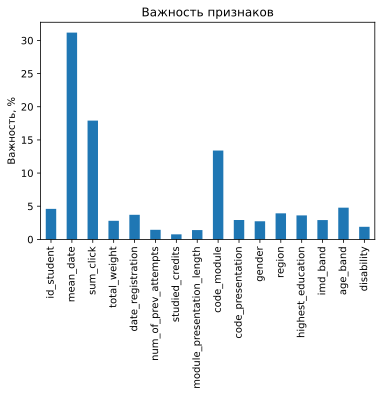

In [108]:
cat_ = pd.Series(catboost.get_feature_importance(),
                         col)
fig, ax = plt.subplots()
cat_.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
plt.show()

In [138]:
columns_to_drop = ['id_student', 'total_weight', 'num_of_prev_attempts', 'studied_credits', 'gender']

In [140]:
X_all_columns = df.iloc[0:train_ind,:][col]
X_drop_low_informative = X.drop(columns=columns_to_drop)
y = Target['final_result']

In [141]:
forest = RandomForestClassifier()
scores = cross_val_score(forest, pd.get_dummies(X_all_columns), y, cv=10, scoring='f1_macro')
scores, np.mean(scores)

(array([0.9075645 , 0.9171767 , 0.91024308, 0.90912565, 0.91752021,
        0.91214633, 0.91176507, 0.91828607, 0.90486409, 0.91520183]),
 0.9123893544717767)

In [142]:
forest = RandomForestClassifier()
scores = cross_val_score(forest, pd.get_dummies(X_drop_low_informative), y, cv=10, scoring='f1_macro')
scores, np.mean(scores)

(array([0.90679488, 0.9133403 , 0.90870878, 0.90989252, 0.92019507,
        0.91060819, 0.91560525, 0.91521022, 0.90409405, 0.91328213]),
 0.9117731379271572)

На всех фичах по мнению достопочтенной кросс-валидации лучше получается, мне честно лень отделять каждую фичу из низкоинформативных и смотреть, вдруг там на 0.005 лучше будет.

# Обучение модели

In [152]:
X_train, X_val, y_train, y_val = train_test_split(X_all_columns, y, test_size = 0.25, random_state = 45)

In [153]:
forest = RandomForestClassifier(n_estimators=1500) # 100 голов хорошо, а 1500 лучше 
forest.fit(pd.get_dummies(X_train), y_train)
pred = forest.predict(pd.get_dummies(X_val))
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      3400
           1       0.88      0.95      0.92      3119

    accuracy                           0.92      6519
   macro avg       0.92      0.92      0.92      6519
weighted avg       0.92      0.92      0.92      6519



# Делаем submission

In [154]:
X_test_ = pd.get_dummies(df.iloc[train_ind:,:][col])

In [156]:
pred = forest.predict(X_test_)

In [158]:
Submission['final_result'] = pred

In [159]:
Submission

final_result
ID                 
26074             1
26075             0
26076             0
26077             0
26078             0
...             ...
32588             0
32589             0
32590             1
32591             1
32592             1

[6519 rows x 1 columns]

Сохраним данные

In [160]:
Submission.to_csv('Sub_clf.csv',index=True)